In [4]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

import numpy as np

import sys
sys.path.append("../../neuroppl/")

import neuroppl as nppl

from neuroppl import utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ImportError: cannot import name 'utils'

In [20]:
a

tensor([1., 1., 1.], dtype=torch.float64)

In [48]:
from scipy.signal import hilbert


data = np.load('./checkpoint/hc5_13_eeg.npz')


# hilbert signal of filtered
eeg_filt = utils.signal.filter_signal(eeg_t, 5., 12., sample_bin)

analytic_signal = hilbert(eeg_filt[:])
#hilbert_amp = np.abs(analytic_signal)
hilbtheta_t = np.unwrap(np.angle(analytic_signal))

In [53]:
np.savez_compressed('./checkpoint/hc5_13_2.npz', arena=arena, eeg_t=eeg_t, 
                    spktrain=spktrain, x_t=x_t, y_t=y_t, s_t=s_t, dir_t=dir_t, hd_t=hd_t, theta_t=theta_t)

In [52]:
data = np.load('./checkpoint/hc5_13_2.npz')
spktrain = data['spktrain']
x_t = data['x_t']
y_t = data['y_t']
s_t = data['s_t']
dir_t = data['dir_t']
hd_t = data['hd_t']
theta_t = data['theta_t']
eeg_t = data['eeg_t']
arena = data['arena']

sample_bin = 0.0008

In [3]:
left_x, right_x, bottom_y, top_y = arena
units_used = spktrain.shape[0]

In [4]:
behav_data = (x_t, y_t)

bin_size = 500
tbin, resamples_, rc_t_, rcov_t = neural_utils.BinTrain(bin_size, sample_bin, spktrain, 
                                                            spktrain[0].shape[0], behav_data, average_behav=True, binned=True)

In [5]:
# Gaussian
filter_size = 1001
t = np.arange(filter_size)
t_cent = (filter_size // 2)
l_filt = 10 # 1000 ms gaussian std
smth_filter = np.exp(-0.5*((t-t_cent)/l_filt)**2)
smth_filter = smth_filter / smth_filter.sum() # normalize

rc_t_g = neural_utils.smoothen_binned_train(rc_t_/tbin, smth_filter, dev)

In [26]:
resamples = 2000
k = 0

rc_t = rc_t_[:, k*resamples:(k+1)*resamples]
rx_t = rcov_t[0][k*resamples:(k+1)*resamples]
ry_t = rcov_t[1][k*resamples:(k+1)*resamples]

### Models with VAE mapping

In [132]:
# idea is to map local trajectories into a latent representation for GPLVM
# contrast with amortized inference where local activity is mapping to latent
hist_len = 10

rc_t = rc_t_[:, k*resamples+hist_len-1:(k+1)*resamples+hist_len-1]
rp_t = np.stack((rcov_t[0][k*resamples:(k+1)*resamples+hist_len-1], 
                 rcov_t[1][k*resamples:(k+1)*resamples+hist_len-1]))
lv_input = tools.lagged_input(rp_t, hist_len=hist_len, hist_stride=1, time_stride=1)
print(lv_input.shape)

# trajectory encoder
traj_enc_1 = tools.MLP([50, 50, 20], lv_input.shape[0], 1, nonlin=tools.Siren, out=None)
traj_enc_1s = tools.MLP([50, 50, 20], lv_input.shape[0], 1, nonlin=tools.Siren, out=None)
traj_enc_1s.net[-1].weight.data.fill_(0.)
traj_enc_1s.net[-1].bias.data.fill_(-10.)

traj_enc_2 = tools.MLP([50, 50, 20], lv_input.shape[0], 1, nonlin=tools.Siren, out=None)
traj_enc_2s = tools.MLP([50, 50, 20], lv_input.shape[0], 1, nonlin=tools.Siren, out=None)
traj_enc_2s.net[-1].weight.data.fill_(0.)
traj_enc_2s.net[-1].bias.data.fill_(-10.)

torch.Size([20, 2000])


tensor([-10.])

In [118]:
# base GP
units_ = 1
prior_tuple = [(None,)]
variational_types = [(None,)]

num_induc = 32
inducing_points = np.array([np.linspace(0, resamples*tbin, num_induc)]).T[None, ...]

l = 1.0*np.ones(units_)
v = np.ones(units_)
kernels_tuples = [('variance', v), ('OU', 'euclid', np.array([l]))]
gp_base_1 = mdl.nonparametrics.Gaussian_process(1, inducing_points, kernels_tuples, 
                                          prior_tuple, variational_types, # mean fixed to zero by default
                                          shared_kernel_params=False, cov_type='factorized',
                                          inv_link='identity', whiten=True)

l = 1.0*np.ones(units_)
v = np.ones(units_)
kernels_tuples = [('variance', v), ('OU', 'euclid', np.array([l]))]
gp_base_2 = mdl.nonparametrics.Gaussian_process(1, inducing_points, kernels_tuples, 
                                          prior_tuple, variational_types, # mean fixed to zero by default
                                          shared_kernel_params=False, cov_type='factorized',
                                          inv_link='identity', whiten=True)

gp_base_1.set_params(tbin, jitter=1e-5)
gp_base_2.set_params(tbin, jitter=1e-5)

times_input = np.linspace(0, resamples*tbin, resamples)
gp_base_1.preprocess([times_input], resamples, batch_size=2000)
gp_base_2.preprocess([times_input], resamples, batch_size=2000)

In [133]:
# GPLVM or Deep GP
units_ = units_used#1
l = .5*np.ones(units_)
v = np.ones(units_)
kernels_tuples = [('variance', v), ('RBF', 'euclid', np.array([l, l]))]#, ('RBF', 'euclid', np.array([l]))]
#prior_tuple = [('Normal', 'euclid', 0.0, rx_t.std(), False, False), ('Normal', 'euclid', 0.0, ry_t.std(), False, False)]
#prior_tuple = [('GP', gp_base_1), ('GP', gp_base_2)]
prior_tuple = [('Normal', 'euclid', 0.0, 1.0, False, False), 
               ('Normal', 'euclid', 0.0, 1.0, False, False)]
#variational_types = [('Normal', 'euclid'), ('Normal', 'euclid')]
variational_types = [('VAE', 'euclid'), ('VAE', 'euclid')]

num_induc = 16
inducing_points = np.array([np.linspace(-1., 1, num_induc), \
                            np.random.randn(num_induc)]).T[None, ...].repeat(units_used, axis=0)

gp_lvm = mdl.nonparametrics.Gaussian_process(units_used, inducing_points, kernels_tuples, 
                                          prior_tuple, variational_types, 
                                          shared_kernel_params=False, cov_type='factorized', whiten=True)
gp_lvm.set_params(tbin, jitter=1e-5)


#log_var = np.zeros(units_used)
#likelihood = mdl.likelihoods.Gaussian(units_used, 'exp', log_var=log_var)
likelihood = mdl.likelihoods.Poisson(units_used, 'exp')
#r_inv = np.ones(units_used)
#likelihood = mdl.likelihoods.Negative_binomial(units_used, 'exp', r_inv)
likelihood.set_params(tbin)

# NLL model
glm = mdl.inference.nll_optimized([gp_lvm], likelihood)

In [134]:
# preprocessing
ini_X = [(np.random.randn(resamples, 2))*0.1, 
         (np.random.randn(resamples, 2))*0.1]
ini_X[0][:, 1].fill(0.01) # std of variational distribution
ini_X[1][:, 1].fill(0.01) # std of variational distribution

nx = (rx_t-rx_t.mean())/rx_t.std()
ny = (ry_t-ry_t.mean())/ry_t.std()
ini_X[0][:, 0] = nx
ini_X[1][:, 0] = ny

ini_X = [(traj_enc_1, traj_enc_1s), 
         (traj_enc_2, traj_enc_2s)]

glm.preprocess(ini_X, resamples, rc_t, batch_size=2000)
glm.to(dev)

sch = lambda o: optim.lr_scheduler.MultiplicativeLR(o, lambda e: 0.9)
opt_tuple = (optim.Adam, 100, sch)
opt_lr_dict = {'default': 1e-2, 
               'rate_model.0.lv_std_0': 1e-4, 
               'rate_model.0.lv_std_1': 1e-4, 
               'rate_model.0.p_0.kernel.kern0._variance': 0., 
               'rate_model.0.p_1.kernel.kern0._variance': 0.}

for n in list(dict(glm.rate_model[0].lv_std_0.named_parameters()).keys()):
    opt_lr_dict['rate_model.0.lv_std_0.'+n] = 1e-6
for n in list(dict(glm.rate_model[0].lv_std_1.named_parameters()).keys()):
    opt_lr_dict['rate_model.0.lv_std_1.'+n] = 1e-6
    
for n in list(dict(glm.rate_model[0].lv_mu_0.named_parameters()).keys()):
    opt_lr_dict['rate_model.0.lv_mu_0.'+n] = 1e-1
for n in list(dict(glm.rate_model[0].lv_mu_1.named_parameters()).keys()):
    opt_lr_dict['rate_model.0.lv_mu_1.'+n] = 1e-1

glm.set_optimizers(opt_tuple, opt_lr_dict)

The parameter rate_model.0.lv_std_0 is not found in the model.
The parameter rate_model.0.lv_std_1 is not found in the model.
The parameter rate_model.0.p_0.kernel.kern0._variance is not found in the model.
The parameter rate_model.0.p_1.kernel.kern0._variance is not found in the model.


In [135]:
# fitting
annealing = lambda x: 1.0#min(1.0, 0.005*x)
losses = glm.fit(3000, loss_margin=-1e0, stop_iters=100, anneal_func=annealing, 
                 cov_samples=16, ll_samples=50, ll_mode='GH', lv_input=lv_input)

plt.figure()
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('NLL')
plt.show()

KeyboardInterrupt: 

In [15]:
glm.rate_model[0].p_1.kernel.kern1.lengthscale.flatten()

tensor([1.7828], device='cuda:0', grad_fn=<ViewBackward>)

In [136]:
X_loc, X_std = gp_lvm.eval_X(lv_input)

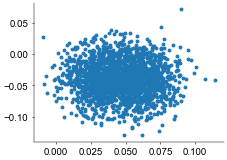

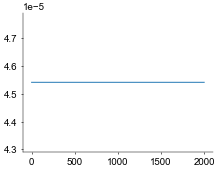

In [137]:
plt.scatter(X_loc[0][:2000], X_loc[1][:2000])
plt.show()

plt.plot(X_std[0])

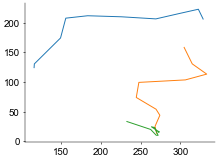

In [76]:
for t in [0, 10, 20]:
    plt.plot(lv_input[:hist_len, t], lv_input[hist_len:, t])

In [21]:
X_loc, X_std = gp_lvm.eval_X()

rcov = np.concatenate((rx_t[None], ry_t[None]), axis=0)
W_, bias_, scale_, losses_ = tools.align_affine_2D(np.array(X_loc), rcov, dev='cpu', iters=20000)

aligned_loc = scale_[:, None]*(W_ @ np.array(X_loc) + bias_[:, None])
aligned_std = np.sqrt(scale_[:, None]**2 *((W_**2).T @ np.array(X_std)**2))

5564.404245965137
7877.264941363275
8309.866164008648
5564.404433815367


In [13]:
covariates = np.arange(resamples)*tbin

lat_mean1, lat_var1 = gp_base_1(torch.tensor(covariates[None, :, None]).float().to(dev))
lat_mean2, lat_var2 = gp_base_2(torch.tensor(covariates[None, :, None]).float().to(dev))

lat_mean = np.concatenate((lat_mean1.data.cpu().numpy()[0], lat_mean2.data.cpu().numpy()[0]), axis=0)
lat_dvar = np.concatenate((lat_var1.data.cpu().numpy()[0], lat_var2.data.cpu().numpy()[0]), axis=0)

post_mean = scale_[:, None]*(W_ @ lat_mean + bias_[:, None])
post_std = np.sqrt(scale_[:, None]**2 *((W_**2).T @ lat_dvar))

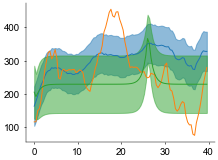

In [14]:
TT = 100

ax = plt.gca()
tx = np.arange(TT)*tbin

line, = ax.plot(tx, aligned_loc[0][:TT])
ax.fill_between(
    tx, aligned_loc[0][:TT]-aligned_std[0][:TT],
    aligned_loc[0][:TT]+aligned_std[0][:TT], color=line.get_color(), alpha=0.5
)

ax.plot(tx, rx_t[:TT])

line, = ax.plot(tx, post_mean[0][:TT])
ax.fill_between(
    tx, post_mean[0][:TT]-post_std[0][:TT],
    post_mean[0][:TT]+post_std[0][:TT], color=line.get_color(), alpha=0.5
)


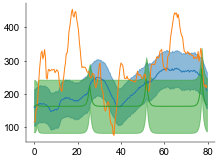

In [15]:
TT = 200

ax = plt.gca()
tx = np.arange(TT)*tbin

line, = ax.plot(tx, aligned_loc[1][:TT])
ax.fill_between(
    tx, aligned_loc[1][:TT]-aligned_std[1][:TT],
    aligned_loc[1][:TT]+aligned_std[1][:TT], color=line.get_color(), alpha=0.5
)

ax.plot(tx, rx_t[:TT])

line, = ax.plot(tx, post_mean[1][:TT])
ax.fill_between(
    tx, post_mean[1][:TT]-post_std[1][:TT],
    post_mean[1][:TT]+post_std[1][:TT], color=line.get_color(), alpha=0.5
)

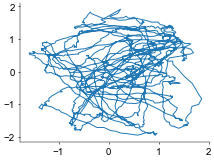

In [16]:
plt.plot(X_loc[0], X_loc[1])

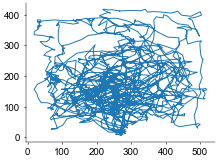

In [17]:
plt.plot(rx_t, ry_t)

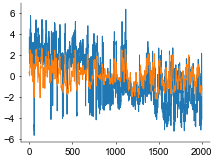

In [34]:
plt.plot(X_loc[0][:2000], '-')
plt.plot(nx[:2000])

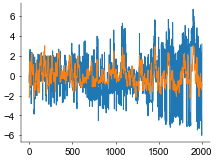

In [35]:
plt.plot(X_loc[1][:], '-')
plt.plot(ny[:])

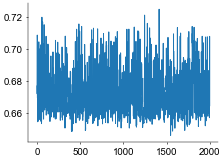

In [27]:
plt.plot(X_std[0])

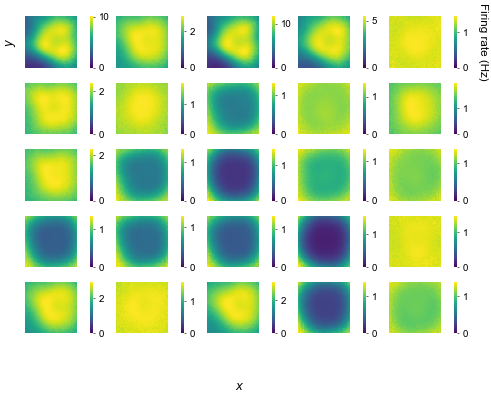

In [79]:
# show fits
grid_size = (50, 40)
#grid_shape = [[left_x, right_x], [bottom_y, top_y]]
grid_shape = [[-3., 3.], \
              [-3., 3.]]
show_neurons = np.arange(25)

fig = plt.figure(figsize=(8, 6))
nrows = 5
ncols = 5
axes = [ fig.add_subplot(nrows, ncols, r * ncols + c + 1) for r in range(0, nrows) for c in range(0, ncols) ]

for m, neuron in enumerate(show_neurons):
    
    def func(pos):
        prevshape = pos.shape[1:]
        x = pos[0].flatten()
        y = pos[1].flatten()
        covariates = np.array([x, y])
        return gp_lvm.eval_rate(covariates, [neuron])[0].reshape(*prevshape)

    if neuron == 4:
        #cbar = True
        ticktitle='Firing rate (Hz)'
    else:
        #cbar = False
        ticktitle=''
        
    _, field = tools.compute_mesh(grid_size, grid_shape, func)
    #grid_shape = [[-2., 2.], [-2., 2.]]
    _, ax = tools.visualize_field(field, grid_shape, ticktitle=ticktitle, figax=(fig, axes[m]))
    if m == 0:
        ylabel=r'$y$'
    else:
        ylabel=None
    tools.decorate_ax(ax, ylabel=ylabel, spines=[False, False, False, False])
    #xlim=[left_x, right_x], ylim=[bottom_y, top_y],

fig.text(0.51, 0.0, r'$x$', ha='center', va='center', fontsize=12)

fig.subplots_adjust(hspace=0.3, wspace=0.3)


plt.show()